# Intel Stock Price (INTC) Forecasting -- GRU+LSTM Classification

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

In [ ]:
#pip show tensorflow

import pkg_resources

try:
    tensorflow_version = pkg_resources.get_distribution("tensorflow").version
    print("TensorFlow Version:", tensorflow_version)
except pkg_resources.DistributionNotFound:
    print("TensorFlow is not installed")


TensorFlow Version: 2.11.1


In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.optimizers import SGD, Adam
from keras import layers

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

from sklearn.metrics import accuracy_score, f1_score, precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc



In [ ]:
INTC = pd.read_csv('INTC.csv')
INTC

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400
...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800


In [ ]:
INTCB = INTC.copy()

# Create a new column 'Return' and initialize it to 0
INTCB['Change'] = 0

for i in range(1, len(INTCB)):

    Change = (INTCB.loc[i, 'Close'] - INTCB.loc[i-1, 'Close']) / INTCB.loc[i-1, 'Close']

    if Change > 0:
        INTCB.loc[i, 'Change'] = 1  # Represents an increase, denoted as 1
    else:
        INTCB.loc[i, 'Change'] = 0  # Represents a decrease or no change, denoted as 0

INTCB

,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200,0
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600,0
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000,1
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200,0
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400,1
...,...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800,0
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400,0
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700,1
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800,1


In [ ]:
data=INTCB['Change']

In [ ]:

split =int(0.8*data.shape[0])
Train,Test  = data[0:split] , data[split:]

val_split=int(0.8*Train.shape[0])
Train,Val=Train[0:val_split] , Train[val_split:]
Val=Val.reset_index(drop=True)
#Test=Test.reset_index(drop=True)


In [ ]:
Test

4712    0
4713    0
4714    1
4715    1
4716    0
       ..
5885    0
5886    0
5887    1
5888    1
5889    1
Name: Change, Length: 1178, dtype: int64

In [ ]:
Test=Test.reset_index(drop=True)
Test

0       0
1       0
2       1
3       1
4       0
       ..
1173    0
1174    0
1175    1
1176    1
1177    1
Name: Change, Length: 1178, dtype: int64

In [ ]:

#需將資料做reshape的動作，使其shape為(資料長度,1)
train_set= Train.values.reshape(-1,1)
val_set= Val.values.reshape(-1,1)
test_set = Test.values.reshape(-1,1)


X_train = []
y_train = []
for i in range(5,len(train_set)):
    X_train.append(train_set[i-5:i])
    y_train.append(train_set[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_val = []
y_val = []
for i in range(5,len(val_set)):
    X_val.append(val_set[i-5:i])
    y_val.append(val_set[i])
X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val,(X_val.shape[0], X_val.shape[1], 1))

X_test = []
y_test = []
for i in range(5,len(test_set)):
    X_test.append(test_set[i-5:i])
    y_test.append(test_set[i])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_train[0]

array([[0],
       [0],
       [1],
       [0],
       [1]])

## Build model & Compile & Fit

In [ ]:
keras.backend.clear_session()
model = Sequential()

model.add(layers.GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#model.add(layers.GRU(units=64, return_sequences=True, activation='tanh'))
#model.add(layers.Dropout(0.5))

model.add(layers.LSTM(units=32, activation='tanh'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=1))

opt = Adam(learning_rate=0.001, beta_1=0.95)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             12864     
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 25,313
Trainable params: 25,313
Non-trainable params: 0
_________________________________________________________________


## Plot the history of training and validation

In [ ]:
history = model.fit(X_train, y_train, epochs = 250, batch_size = 128, validation_data=(X_val,y_val))

Epoch 1/250
30/30 [==============================] - 2s 14ms/step - loss: 0.9985 - accuracy: 0.4849 - val_loss: 0.7226 - val_accuracy: 0.4787
Epoch 2/250
30/30 [==============================] - 0s 4ms/step - loss: 0.7673 - accuracy: 0.4955 - val_loss: 0.7325 - val_accuracy: 0.4861
Epoch 3/250
30/30 [==============================] - 0s 4ms/step - loss: 0.7479 - accuracy: 0.4827 - val_loss: 0.7051 - val_accuracy: 0.4957
Epoch 4/250
30/30 [==============================] - 0s 4ms/step - loss: 0.7357 - accuracy: 0.4952 - val_loss: 0.7064 - val_accuracy: 0.4829
Epoch 5/250
30/30 [==============================] - 0s 4ms/step - loss: 0.7251 - accuracy: 0.5011 - val_loss: 0.6997 - val_accuracy: 0.4755
Epoch 6/250
30/30 [==============================] - 0s 5ms/step - loss: 0.7280 - accuracy: 0.4910 - val_loss: 0.7002 - val_accuracy: 0.4904
Epoch 7/250
30/30 [==============================] - 0s 4ms/step - loss: 0.7205 - accuracy: 0.4894 - val_loss: 0.6970 - val_accuracy: 0.4915
Epoch 8/250


In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

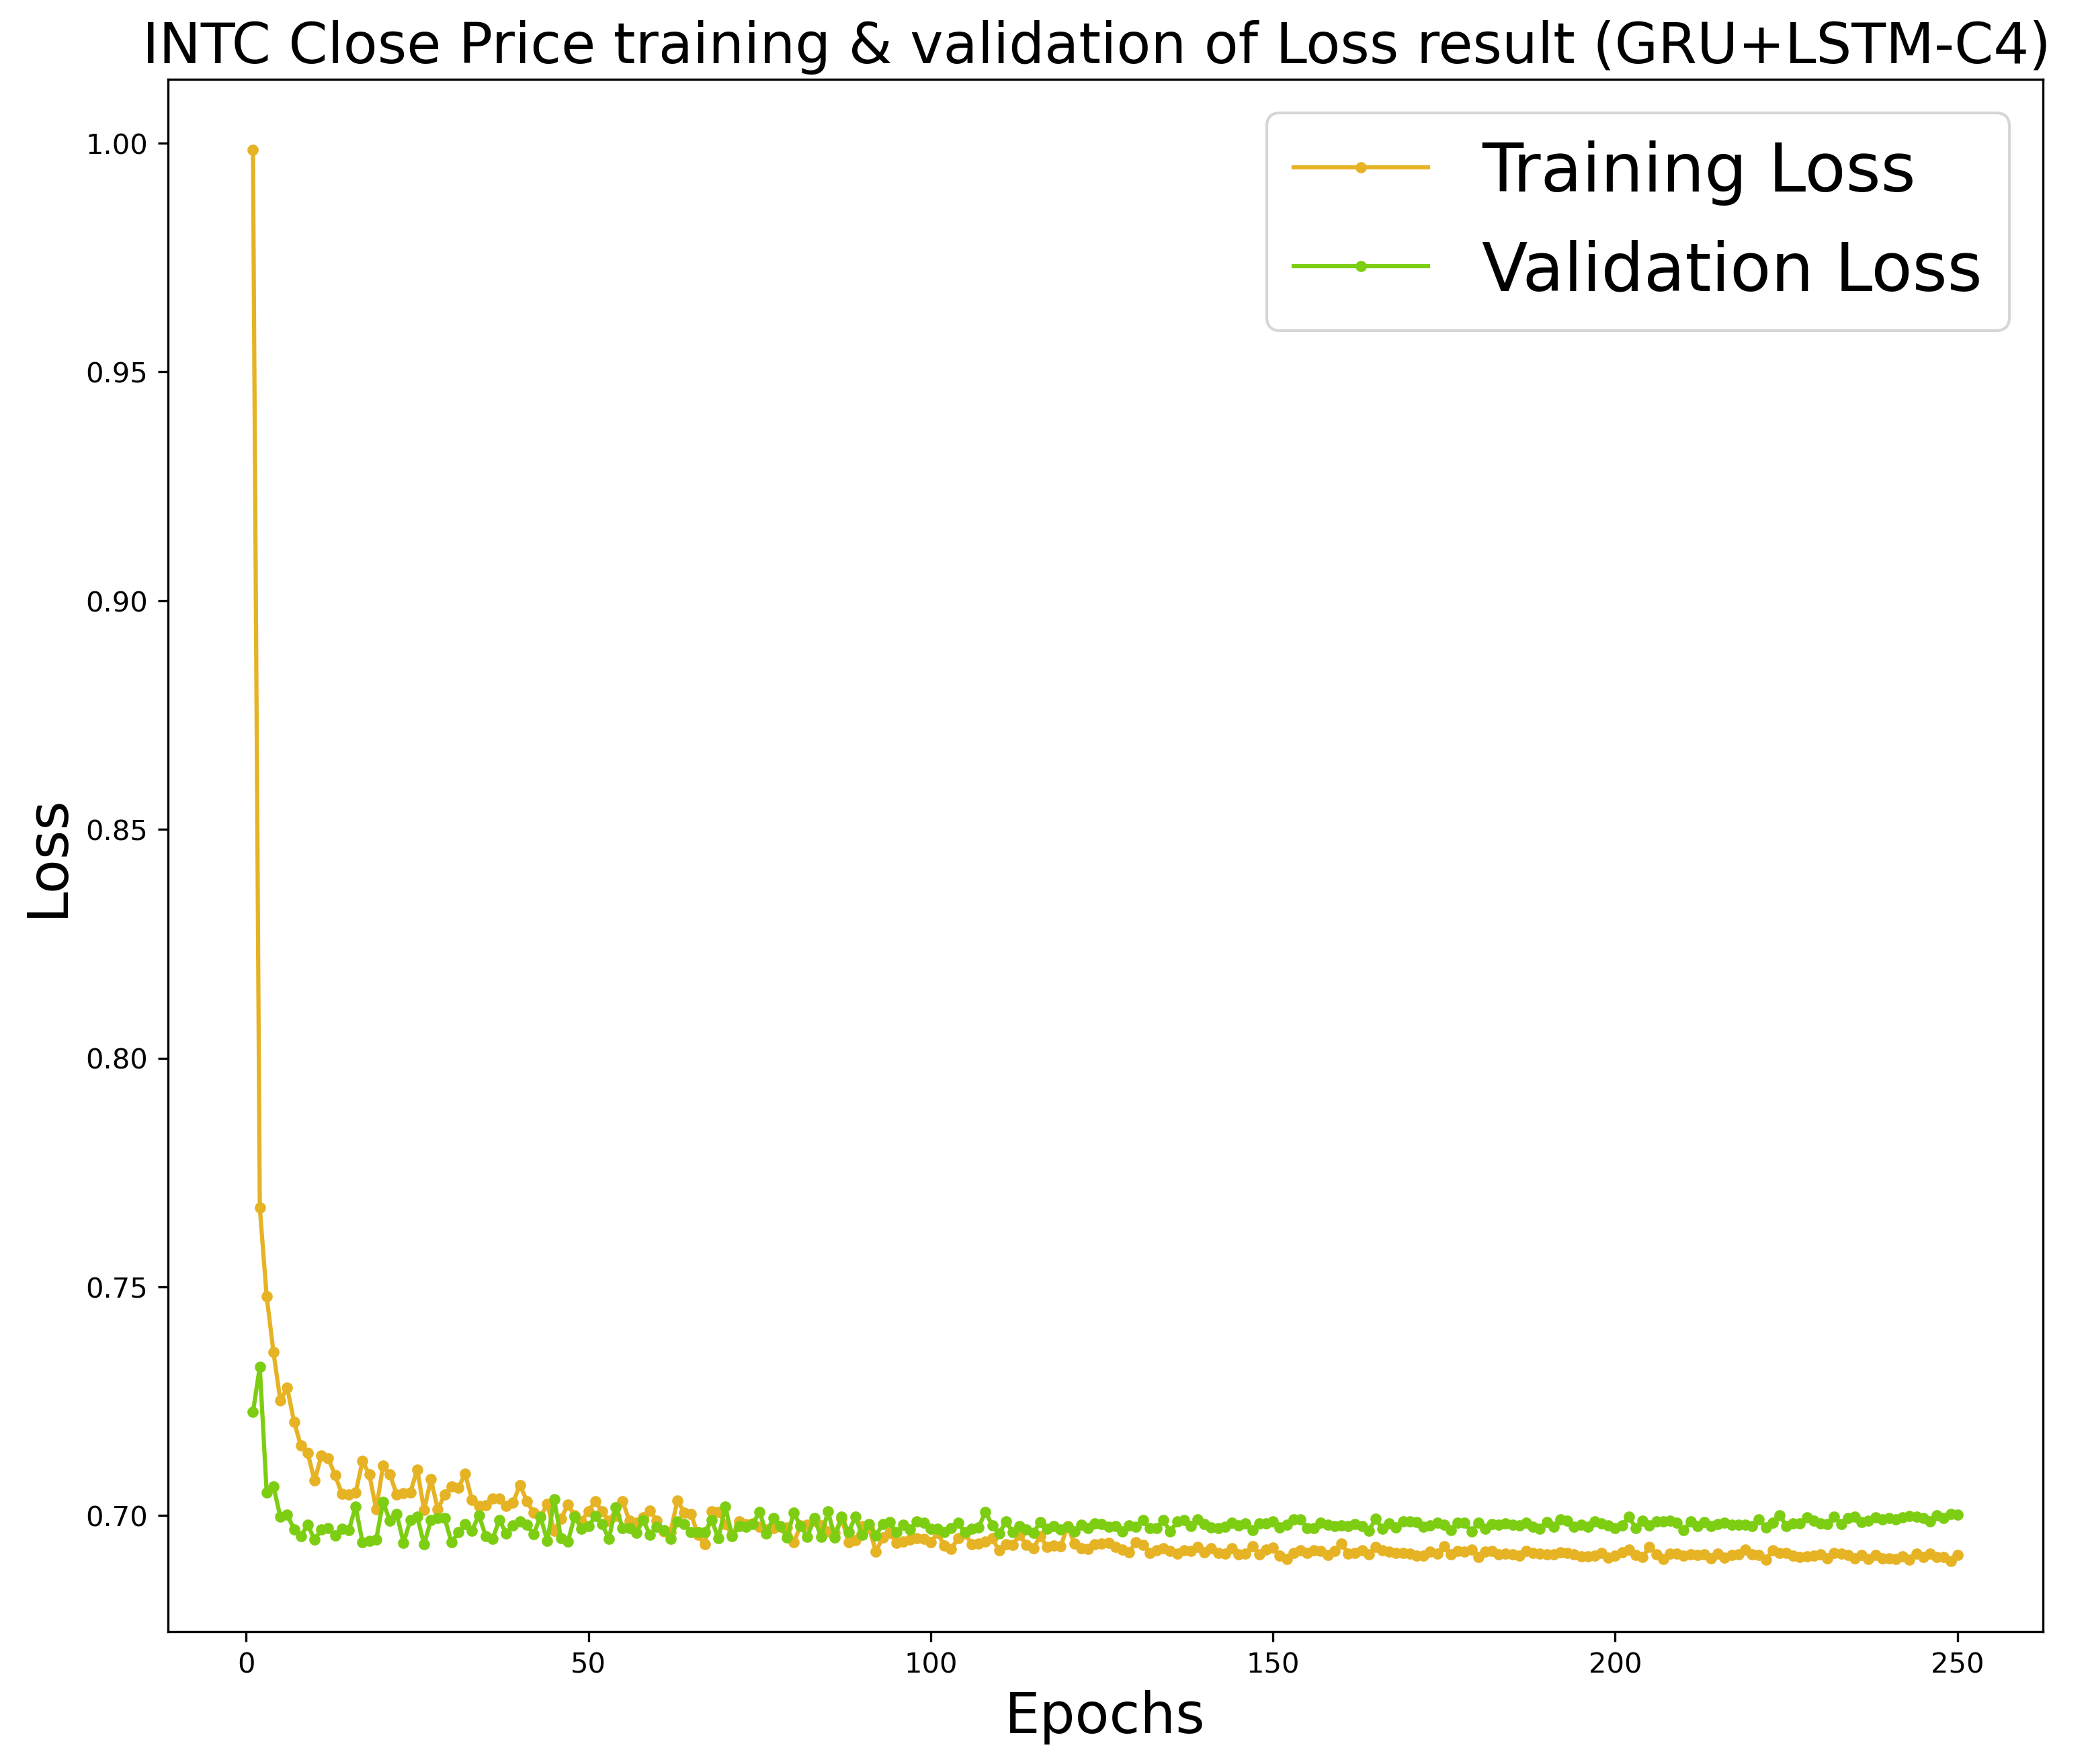

In [ ]:
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('INTC Close Price training & validation of Loss result (GRU+LSTM-C4) ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='Training Loss', color = '#E6B325')
plt.plot(epochs, val_loss_values,marker='.',label='Validation Loss', color = '#7DCE13')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
model.save('INTC STOCK GRULSTM_trained_model_C.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
GRULSTM_model_C = keras.models.load_model('INTC STOCK GRULSTM_trained_model_C.h5')
print('Model successfully loaded...')

Model successfully loaded...


In [ ]:
predicted = GRULSTM_model_C.predict_on_batch(X_test)
predicted

array([[0.51377255],
       [0.4716322 ],
       [0.47069535],
       ...,
       [0.49317288],
       [0.48586848],
       [0.5355906 ]], dtype=float32)

In [ ]:
# 8.2 Transform the predictions to 0 and 1
testing_prediction=(model.predict_on_batch(X_test) >= 0.5).astype('int')
testing_prediction

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
# 8.3 Calculating the mertics
testing_acc=accuracy_score(y_test,testing_prediction)
testing_f1s=f1_score(y_test,testing_prediction,pos_label=1)
testing_pre=precision_score(y_test,testing_prediction,pos_label=1)
testing_sen=sensitivity_score(y_test,testing_prediction,pos_label=1)
testing_spe=specificity_score(y_test,testing_prediction,pos_label=1)
testing_cm=confusion_matrix(y_test,testing_prediction)
print('Testing Result:')
print('Testing Accuracy Score:',round(testing_acc*100,2))
print('Testing f1 Score:',round(testing_f1s*100,2))
print('Testing Precision Score:',round(testing_pre*100,2))
print('Testing Sensitivity Score:',round(testing_sen*100,2))
print('Testing Specificity Score:',round(testing_spe*100,2))
print('')
print('Testing Confusion Matrix:')
print(testing_cm)

Testing Result:
Testing Accuracy Score: 52.26
Testing f1 Score: 44.88
Testing Precision Score: 51.82
Testing Sensitivity Score: 39.58
Testing Specificity Score: 64.49

Testing Confusion Matrix:
[[385 212]
 [348 228]]


<Figure size 1500x1500 with 0 Axes>

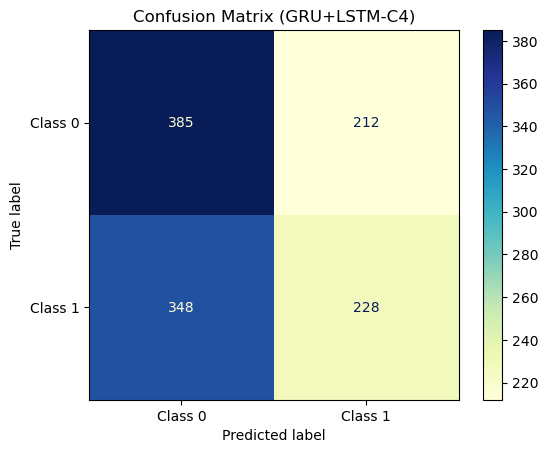

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix = testing_cm, display_labels = ["Class 0", "Class 1"])
plt.figure(figsize=(10, 10), dpi=150)
display.plot(cmap='YlGnBu')
plt.title("Confusion Matrix (GRU+LSTM-C4)")
plt.show()

In [ ]:
# ROC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, testing_prediction)

# AUC
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5203622278056951

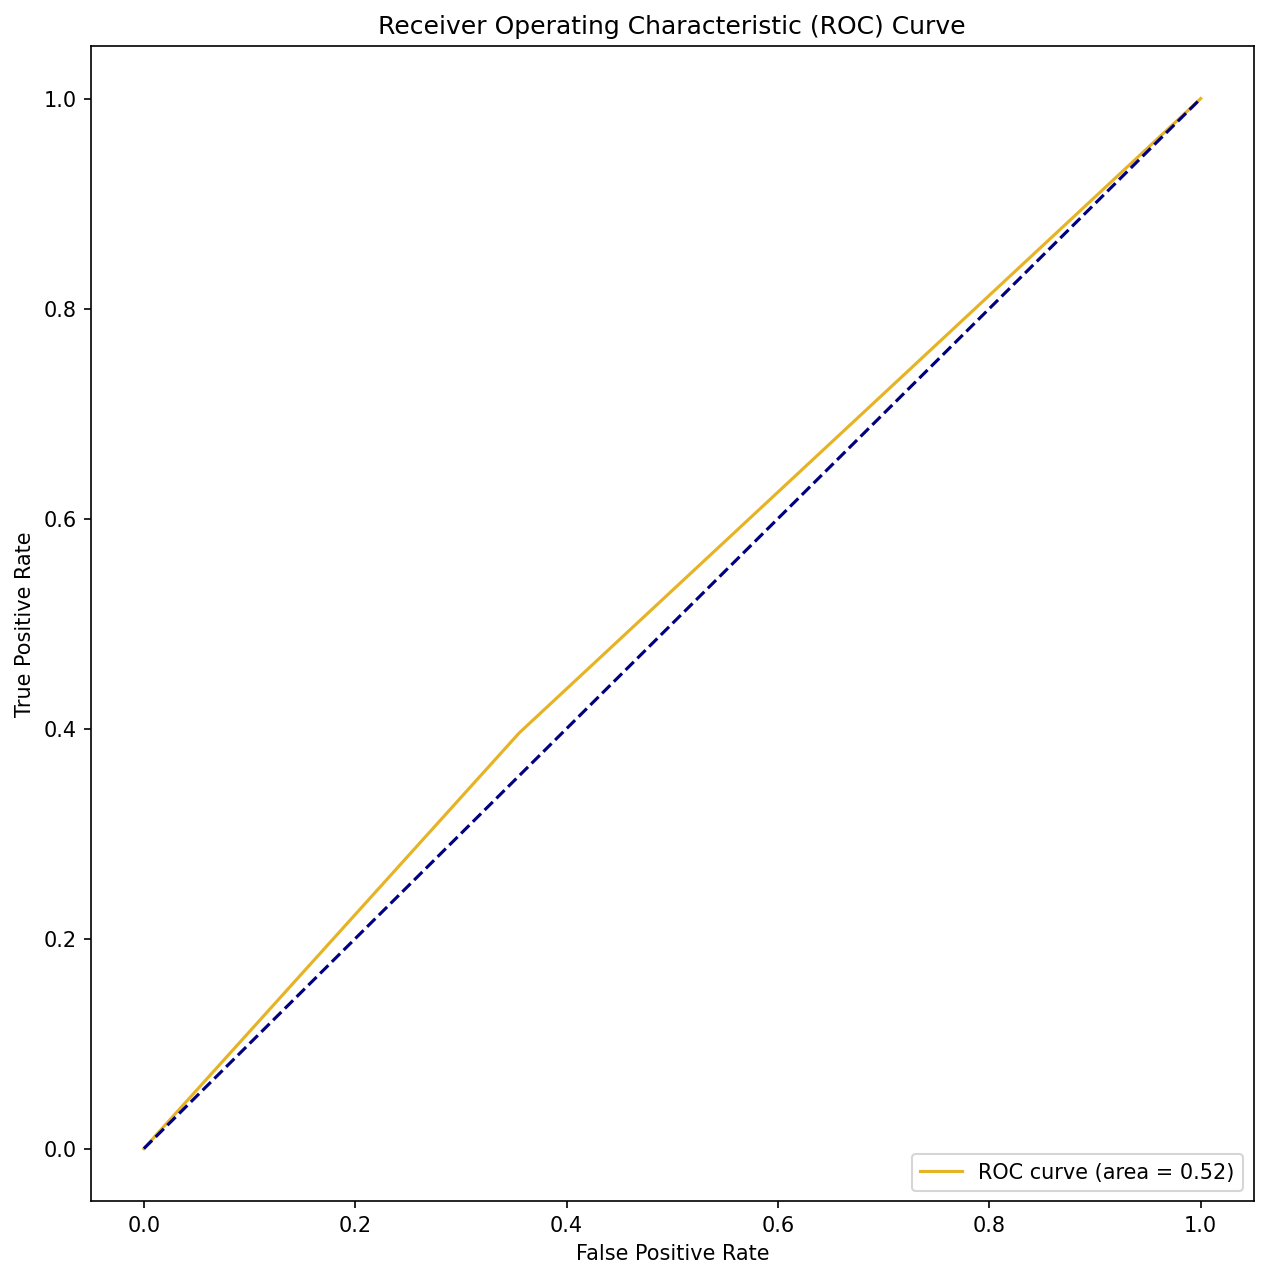

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(10, 10), dpi=150)
plt.plot(false_positive_rate, true_positive_rate, color='#E6B325', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
